# Define the Zernike Polynomials

In [1]:
function R(n::Int64, m::Int64, ρ::Float64, scale::Float64=1E-6)
    """Following the naming convention on Wikipedia for R_n^m: https://en.wikipedia.org/wiki/Zernike_polynomials"""
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            if ρ == 0
                0
            else
                (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ/scale)^(n-2*k)
            end
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end

function Z(n::Int64, m::Int64)
    """In John's notes he includes a normalization, we have omitted that and are just following the conventions
    on Wikipedia."""
    function Z_at_point(ρ::Float64, ϕ::Float64)
        if m >= 0
            R(n, m, ρ) * cos(m * ϕ)
        else
            R(n, -m, ρ) * sin(-m * ϕ)
        end
    end
    Z_at_point
end


Z (generic function with 1 method)

In [2]:
function plot_across_disk(f, discretization::Int64, radius::Float64)
    x = y = Array(range(-radius, radius, length=discretization))
    z = Array{typeof(f(0.,0.))}(UndefInitializer(), length(x), length(y))
    for (i, xx) in enumerate(x)
        for (j, yy) in enumerate(y)
            if xx^2 + yy^2 > radius^2
                if typeof(f(0.,0.)) == Tuple{Float64,Float64}
                    z[i, j] = (0.,0.)
                else
                    z[i, j] = 0.
                end
            else
                ρ = sqrt(xx^2 + yy^2)
                ϕ = atan(yy, xx)
                res = f(ρ, ϕ)
                z[i, j] = res
            end
        end
    end
    x, y, z
end

plot_across_disk (generic function with 1 method)

In [3]:
using Plots
width = 1E-6
discretization = 100
function zernike_func(ρ, coefficients)
    reduce(+, [coefficients[i] * R(length(coefficients)-1, i-1, ρ) for i in Array(range(1, length(coefficients), step=1))])
end

zernike_func (generic function with 1 method)

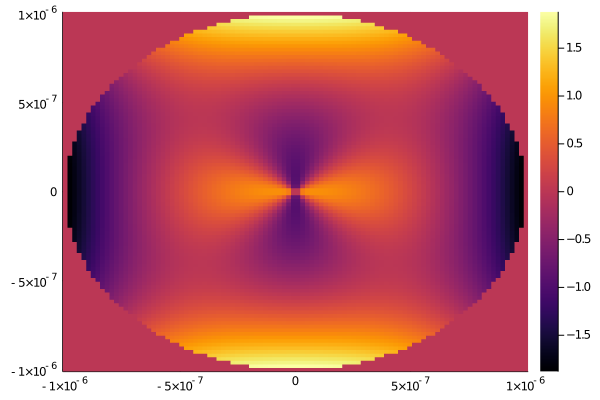

In [4]:
# The middle coeffcient has no effect - if n-m is odd, R is zero!
coeffs = [1, 0, 1]
plot(
    heatmap(plot_across_disk((ρ, ϕ) -> zernike_func(ρ, coeffs) * cos((length(coeffs) - 1) * ϕ), discretization, width)))

In [5]:
using SpecialFunctions
function H_odf(ρ::Float64, ϕ::Float64, t::Float64,
        zernike_coefficients_even::Array, zernike_coefficients_odd::Array=[0],
        U::Float64=2*π*10E3, ψ::Float64=0.; μ::Float64=0.0, ω::Float64=2*π*43.8E3, bessel=false, small=false)
    """ϕ is the phase offset in the rotating frame."""
    
    neven = length(zernike_coefficients_even) - 1
    Peven = reduce(+, [zernike_coefficients_even[i] * R(neven, i-1, ρ) for i in Array(range(1, neven + 1, step=1))])
    nodd = length(zernike_coefficients_odd) - 1
    Podd = reduce(+, [zernike_coefficients_odd[i] * R(nodd, i-1, ρ) for i in Array(range(1, nodd + 1, step=1))])

    rotationeven = - (neven) * ω * t
    rotationodd = - (nodd) * ω * t
    
    if bessel && small
        U/2 * (Peven * sin(neven * ϕ - ψ) - Podd * cos(nodd * ϕ - ψ))
    elseif bessel && !small
        # Ignores ω and assumes n = -1
        U * (besselj1(Peven) * sin(neven * ϕ - ψ) - besselj1(Podd) * cos(nodd * ϕ - ψ))
    else
        U * sin(-μ*t + ψ + Peven * cos(neven * ϕ  + rotationeven) + Podd * sin(nodd * ϕ  + rotationodd))
    end
end

H_odf (generic function with 4 methods)

In [6]:
function first_argmin(x, y=Inf, eps=.1)
    """THIS IS WRONG"""
    mindex = argmin(x)
    minimum = x[mindex]
    if abs(y-minimum) > eps
        mindex
    elseif mindex < length(x)/2
        first_argmin(x[0:argmin], min(minimum, y), eps)
    else
        first_argmin(x[argmin], min(minimum, y), eps)
    end
end

first_argmin (generic function with 3 methods)

In [7]:
using QuantumOptics
function odf_time_evolution(ρ::Float64, ϕ::Float64, zernikeeven::Array, zernikeodd::Array,
        Γ::Float64=1/62, evolution_time::Float64=50.E-6; ω::Float64=2*π*43.8E3, μ::Float64=0.0, optimize=true, bessel=false, small=false)
    # If it's longer than this, we won't see it. We're going to report the excitation at the best time.
    b = SpinBasis(1//2)
    ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
    T = [0:0.01E-6:evolution_time;]
    H(t, ψ) = H_odf(ρ, ϕ, t, zernikeeven, zernikeodd, μ=μ, ω=ω, bessel=bessel, small=small)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
    tout, ρ = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])
    trace = Real.(expect(sigmax(b), ρ))
    if optimize
        minimum(trace), T[first_argmin(trace)] * 1E6
    else
        trace
    end
end

odf_time_evolution (generic function with 3 methods)

In [8]:
μ = (length(coeffs) - 1) * 2 * π * 43.8E3
population(ρ, ϕ) = odf_time_evolution(ρ, ϕ, coeffs, coeffs, μ=μ)

population (generic function with 1 method)

In [9]:
x,y,z = plot_across_disk(population, discretization, width);

In [10]:
z1 = Array{Float64}(undef, size(z)...)
z2 = Array{Float64}(undef, size(z)...)
for (i, el) in enumerate(z)
    z1[i] = el[1]
    z2[i] = el[2]
end

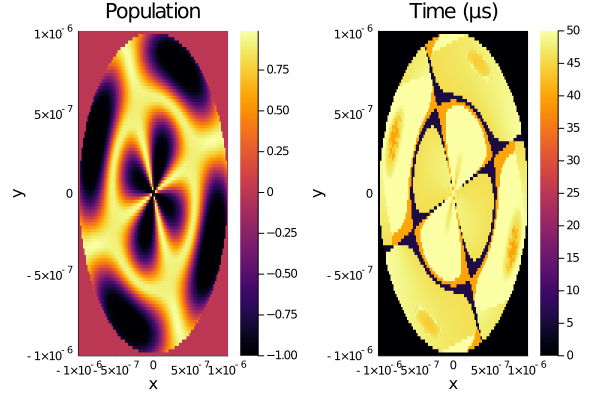

In [11]:
plot(
    heatmap(x, y, z1, xlabel="x", ylabel="y", title="Population"),
    heatmap(x, y, z2, xlabel="x", ylabel="y", title="Time (μs)"))

# Using the parameters from the paper, we see that we can get a pi pulse for the right μ.

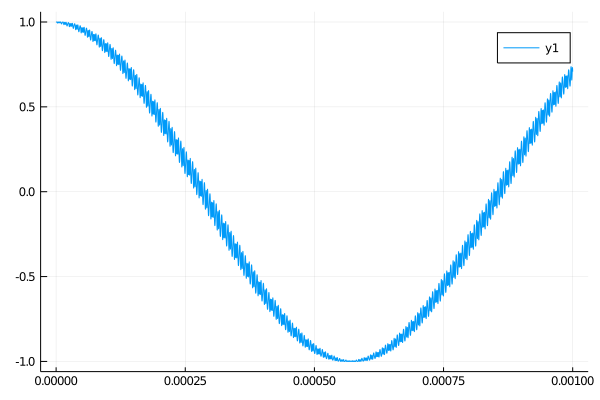

In [12]:
using QuantumOptics
Γ = (1/62) 
rates = [Γ]
ρ = 1E-5
ϕ = 0.
b = SpinBasis(1//2)

# Start in an equal superposition
max_simulation_time = 1000.E-6
ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
T = [0:0.01E-6:max_simulation_time;]

zernike = [0, 1]
μ = (length(zernike) - 1) * 2 * π * 43.8E3

H(t, _) = H_odf(ρ, ϕ, t, zernike, μ=μ) * sigmaz(b), [sigmaz(b)], [dagger(sigmaz(b))]
tout, ψ = timeevolution.master_dynamic(T, ψ0, H; rates=rates)

# Measure in the x basis
excitation = Real.(expect(sigmax(b), ψ))
plot(T, excitation)

# If we choose a bad μ, we can't drive oscillations.

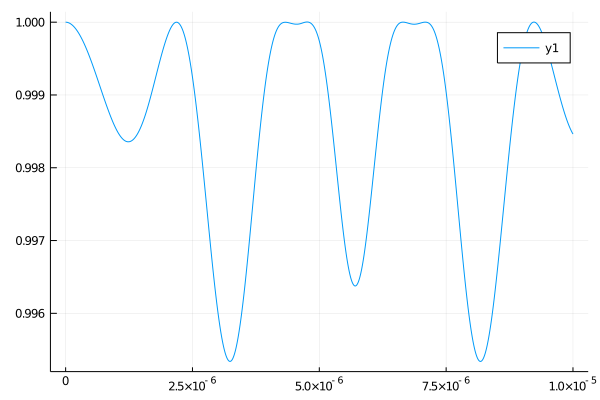

In [13]:
max_simulation_time = 10.E-6
ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
T = [0:0.01E-6:max_simulation_time;]

μ = 0.0
H(t, _) = H_odf(ρ, ϕ, t, zernike, μ=μ) * sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
tout, ψ = timeevolution.master_dynamic(T, ψ0, H; rates=rates)
excitation = Real.(expect(sigmax(b), ψ))
plot(T, excitation)

# If we pick the same μ, but look at a location farther out on the crystal, the curve looks qualitatively different.

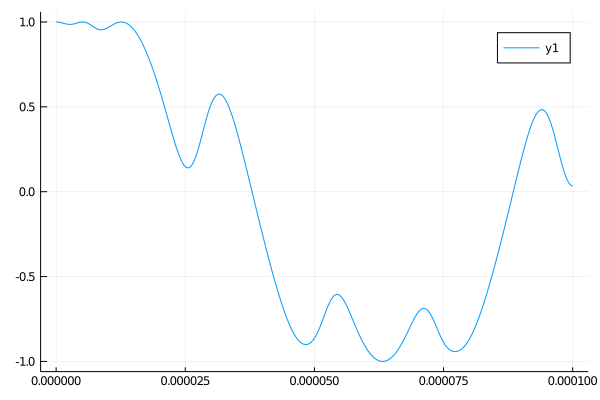

In [14]:
using QuantumOptics
using PyPlot
Γ = (1/62)
ω = 2 * π * 43.8E3
time = 100.E-6
rates = [Γ]
b = SpinBasis(1//2)
ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
T = [0:0.01E-6:time;]
zernike = [0, 1]
μ = (length(zernike) - 1) * ω
H(t, ψ) = H_odf(1E-6, 0., t, zernike, μ=μ)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
tout, ρ = timeevolution.master_dynamic(T, ψ0, H; rates=rates)
excitation = Real.(expect(sigmax(b), ρ))
plot(T, excitation)

# Also depending on which terms (even or odd) it will change.

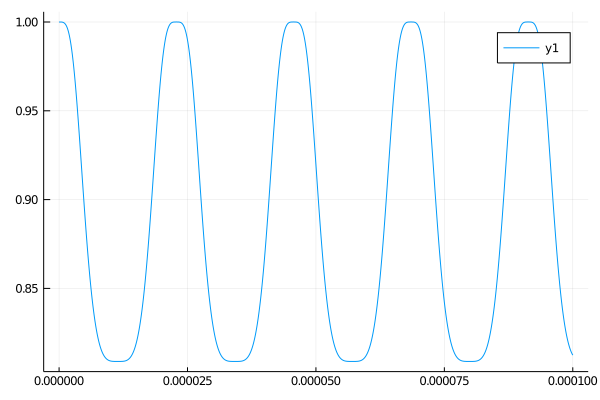

In [15]:
using QuantumOptics
using PyPlot
H(t, ψ) = H_odf(1E-6, 0., t, [0], zernike, μ=μ)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
tout, ρ = timeevolution.master_dynamic(T, ψ0, H; rates=rates)
excitation = Real.(expect(sigmax(b), ρ))
plot(T, excitation)

# We can superimpose them.

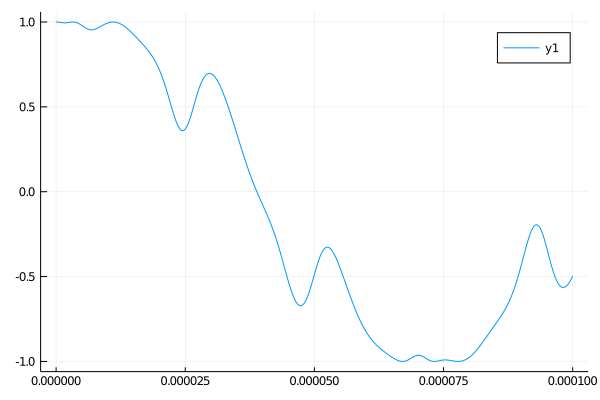

In [16]:
using QuantumOptics
using PyPlot
Γ = (1/62)
ω = 2 * π * 43.8E3
rates = [Γ]
b = SpinBasis(1//2)
ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
T = [0:0.01E-6:time;]
zernike = [0, 1]
μ = (length(zernike) - 1) * ω
H(t, ψ) = H_odf(1E-6, 0., t, zernike, zernike, μ=μ)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
tout, ρ = timeevolution.master_dynamic(T, ψ0, H; rates=rates)
excitation = Real.(expect(sigmax(b), ρ))
plot(T, excitation)

# Or do them sequentially.

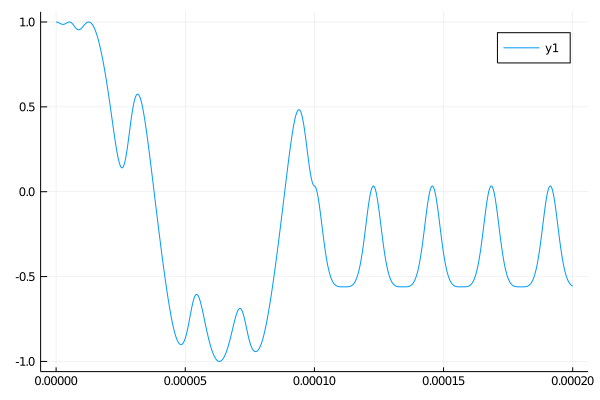

In [17]:
using QuantumOptics
using PyPlot
Γ = (1/62)
ω = 2 * π * 43.8E3
rates = [Γ]
b = SpinBasis(1//2)
ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
T = [0:0.01E-6:2*time;]
zernike = [0, 1]
μ = (length(zernike) - 1) * ω
function H(t, _) 
    if t < time
        H_odf(1E-6, 0., t, zernike, [0], μ=μ)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
    else
        H_odf(1E-6, 0., t-time, [0], zernike, μ=μ)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
    end
end
tout, ρ = timeevolution.master_dynamic(T, ψ0, H; rates=rates)
excitation = Real.(expect(sigmax(b), ρ))
plot(T, excitation)

# Comparing Time Independent and Time Dependent Dynamics

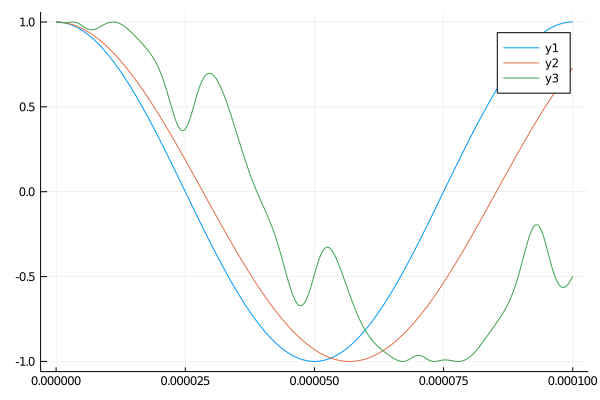

In [20]:
using QuantumOptics
Γ = (1/62) 
rates = [Γ]
ρ = 1E-6
ϕ = 0.
b = SpinBasis(1//2)

# Start with a conservative estimate of gate time, and in an equal superposition
max_simulation_time = 50.E-6
ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))

zernike = [0, 1]
pop, max_simulation_time = odf_time_evolution(ρ, ϕ, zernike, zernike, Γ, max_simulation_time, small=true, bessel=true, optimize=true)

H(t, _) = H_odf(ρ, ϕ, t, zernike, zernike, small=true, bessel=true) * sigmaz(b), [sigmaz(b)], [dagger(sigmaz(b))]
T = [0:0.01E-6:2*max_simulation_time*1E-6;]
tout, ψ = timeevolution.master_dynamic(T, ψ0, H; rates=rates)

ω = 2 * π * 43.8E3
μ = (length(zernike) - 1) * ω
# Measure in the x basis
excitation = Real.(expect(sigmax(b), ψ))
large_bessel = odf_time_evolution(ρ, ϕ, zernike, zernike, Γ, 2*max_simulation_time*1E-6; ω=ω, μ=μ, optimize=false, bessel=true, small=false)
exact = odf_time_evolution(ρ, ϕ, zernike, zernike, Γ, 2*max_simulation_time*1E-6; ω=ω, μ=μ, optimize=false, bessel=false, small=false)
plot(T, [excitation, large_bessel, exact])